In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn")

client = Client(n_workers=4)
print(dgpd.__version__)
client


v0.3.1


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55758,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.69 GiB
Comm: tcp://127.0.0.1:55787,Total threads: 4
Dashboard: http://127.0.0.1:55788/status,Memory: 3.92 GiB
Nanny: tcp://127.0.0.1:55761,


In [2]:
def convert_timezone(utc_df: pd.DataFrame,
                     target_tz: str = "America/New_York",
                     columns: list = ["pick_up_time", "drop_off_time"]):
    new_timezone_df = utc_df.copy()
    start_col, end_col = columns[0], columns[1]
    new_timezone_df[start_col] = new_timezone_df[start_col].dt.tz_convert(
        target_tz)
    new_timezone_df[end_col] = new_timezone_df[end_col].dt.tz_convert(
        target_tz)
    return new_timezone_df



####  Loading data and pre-processing

In [3]:
# raw data
raw_taxi_df = dd.read_csv(r'./raw_data/taxi_id.csv',
                 blocksize=64e6,
                 names=[
                     'taxi_id', 'pick_up_time', 'drop_off_time',
                     'pick_up_intersection', 'drop_of_intersection'
                 ])

# Unix epoch timestamp correspond to UTC
raw_taxi_df['pick_up_time'] = dd.to_datetime(raw_taxi_df['pick_up_time'],
                                             unit='s',
                                             utc=True)
raw_taxi_df['drop_off_time'] = dd.to_datetime(raw_taxi_df['drop_off_time'],
                                              unit="s",
                                              utc=True)
raw_taxi_df['trip_date'] = raw_taxi_df['pick_up_time'].dt.date

# a copy of raw_df with timezone transforming in datetime field
nytz_df = convert_timezone(raw_taxi_df).drop(
    ['drop_off_time', 'pick_up_intersection', "drop_of_intersection"], axis=1)

# extract trip_date and trip_hour in local time
nytz_df['trip_date'] = nytz_df['pick_up_time'].dt.strftime('%Y-%m-%d')
nytz_df['trip_hour'] = nytz_df['pick_up_time'].dt.strftime('%H')
display(raw_taxi_df.head())
display(nytz_df.head())
display(nytz_df.info)


,taxi_id,pick_up_time,drop_off_time,pick_up_intersection,drop_of_intersection,trip_date
0,1,2011-01-01 00:00:00+00:00,2011-01-01 00:14:08+00:00,952,2021,2011-01-01
1,2,2011-01-01 00:00:01+00:00,2011-01-01 00:08:43+00:00,1372,2815,2011-01-01
2,3,2011-01-01 00:00:03+00:00,2011-01-01 00:04:36+00:00,856,1149,2011-01-01
3,4,2011-01-01 00:00:04+00:00,2011-01-01 00:04:59+00:00,2060,1956,2011-01-01
4,5,2011-01-01 00:00:07+00:00,2011-01-01 00:19:19+00:00,2506,1332,2011-01-01


,taxi_id,pick_up_time,trip_date,trip_hour
0,1,2010-12-31 19:00:00-05:00,2010-12-31,19
1,2,2010-12-31 19:00:01-05:00,2010-12-31,19
2,3,2010-12-31 19:00:03-05:00,2010-12-31,19
3,4,2010-12-31 19:00:04-05:00,2010-12-31,19
4,5,2010-12-31 19:00:07-05:00,2010-12-31,19


<bound method DataFrame.info of Dask DataFrame Structure:
               taxi_id                      pick_up_time trip_date trip_hour
npartitions=84                                                              
                 int64  datetime64[ns, America/New_York]    object    object
                   ...                               ...       ...       ...
...                ...                               ...       ...       ...
                   ...                               ...       ...       ...
                   ...                               ...       ...       ...
Dask Name: assign, 23 graph layers>

In [4]:
def plot_trend(
    df: pd.DataFrame,
    data_field="trip_count",
    x_column="trip_date",
    y_column="trip_count",
    emphasis_range=None,
    date = None
):
    """line chart, showing time trend

    Args:
        df (pd.DataFrame): dataframe
        data_field (str, optional): data field. 
        Defaults to "trip_count".
        x_column (str, optional): time field. 
        Defaults to "trip_date".
        y_column (str, optional): ylabel. 
        Defaults to "trip_count".
        palette (list, optional): color space. 
        Defaults to ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"].
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    macaron_colors = ["#FF6B6B", "#FFD166", "#06D6A0", "#277DA1", "#FEAA40"]
    # create figure
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    # plot
    sns.lineplot(
        y=data_field,
        x=x_column,
        data=df,
        # color="b",
        markers=True,
        ax=ax)
    plt.xticks(range(0, 24, 1))
    if len(emphasis_range) >= 1:
        plt.axvspan(
            emphasis_range[0][0],
            emphasis_range[0][1],
            alpha=0.2,
            color=macaron_colors[0],
            label=
            f"Rush Hour ({emphasis_range[0][0]}:00-{emphasis_range[0][1]}:00)",
        )
        plt.axvspan(
            emphasis_range[1][0],
            emphasis_range[1][1],
            alpha=0.2,
            color=macaron_colors[1],
            label=
            f"Rush Hour ({emphasis_range[1][0]}:00-{emphasis_range[1][1]}:00)",
        )
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    if date:
        plt.title(f"Daily Trip Count for {date}")
    else:
        plt.title(f"Daily Trip Count ")
    plt.legend()
    plt.show()


#### 5.1 Randomly selecting dates

In [5]:
# 1. randomly select 3 days in the dataset range
date_sample1, date_sample2, date_sample3 = pd.to_datetime(
    (pd.date_range('2011-01-01',
                   periods=364).to_series().sample(
                       n=3).to_list())).strftime('%Y-%m-%d')
date_sample1


'2011-01-15'

#### 5.2 groupping by date and hour

In [6]:
# calculating the groupping result, groupping rules:by=["trip_date", "trip_hour"]

hourly_trend_in_days = nytz_df[(nytz_df["trip_date"] == date_sample1) |
                       (nytz_df["trip_date"] == date_sample2) |
                       (nytz_df["trip_date"] == date_sample3)][[
                           'trip_date', "trip_hour", "taxi_id"
                       ]].groupby(
                           by=["trip_date", "trip_hour"]).count().rename(
                               columns={"taxi_id": "trip_count"})
_hourly_groupping_res = hourly_trend_in_days.compute()
_hourly_groupping_res = _hourly_groupping_res.reset_index()
display(_hourly_groupping_res.head(24))


,trip_date,trip_hour,trip_count
0,2011-01-05,00,2486
1,2011-01-05,01,8885
2,2011-01-05,02,18615
3,2011-01-05,03,24632
4,2011-01-05,04,22620
5,2011-01-05,05,18256
6,2011-01-05,06,17776
7,2011-01-05,07,19030
8,2011-01-05,08,18683
9,2011-01-05,09,19770


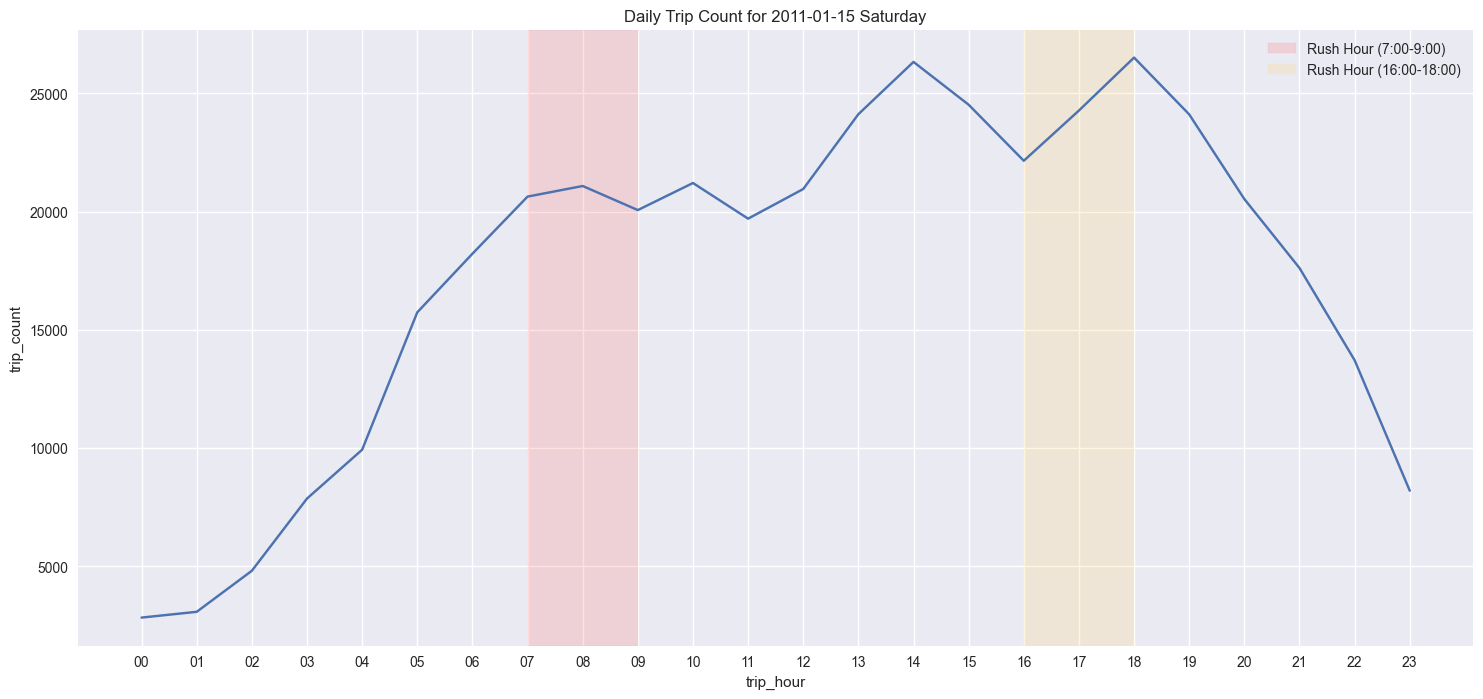

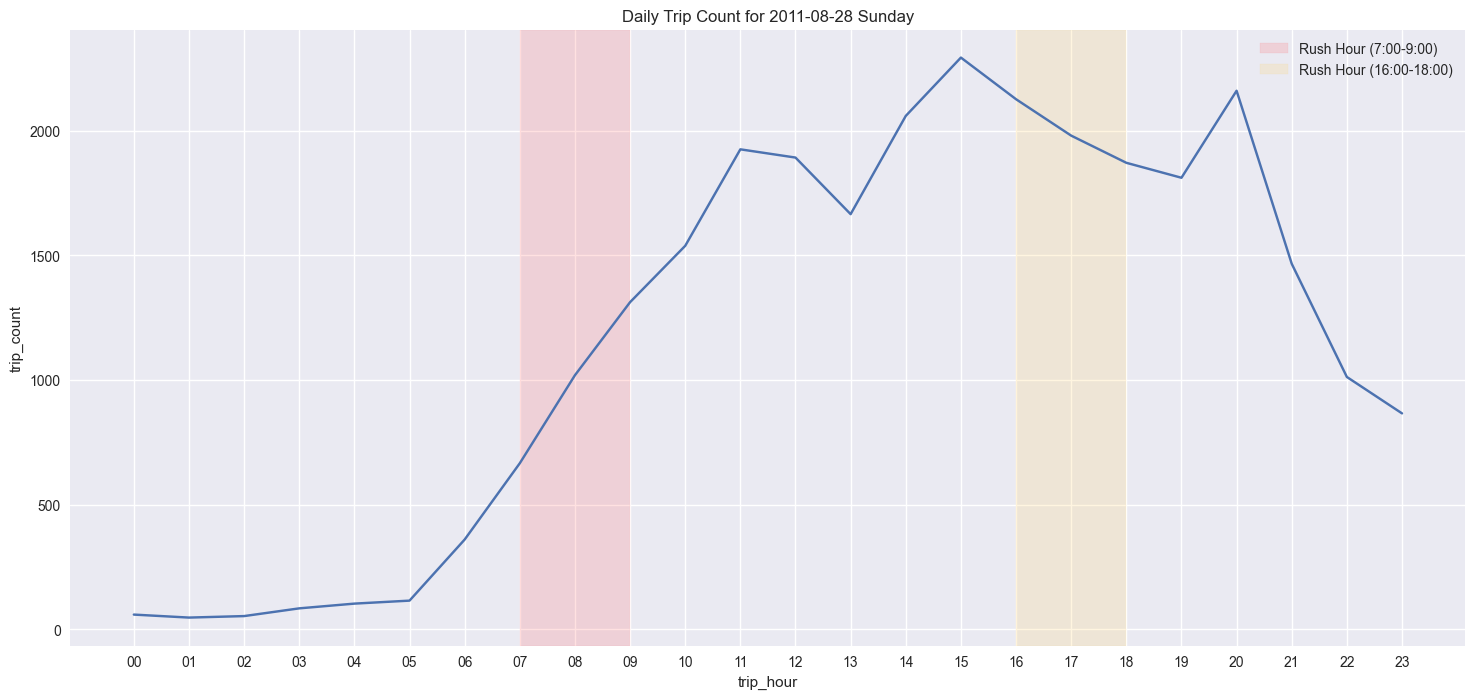

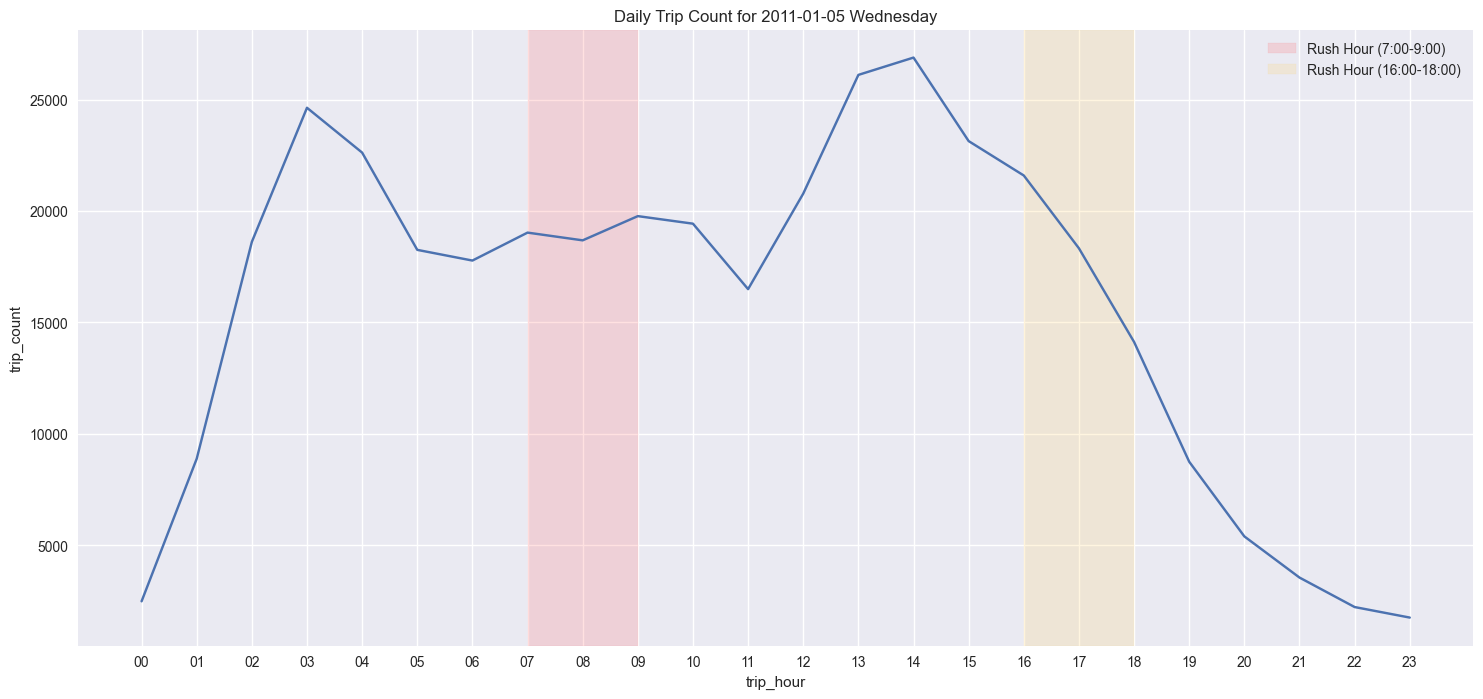

In [7]:
# loop the dates randomly selected and plot them individually
from datetime import datetime
import calendar
for _date in [date_sample1,date_sample2,date_sample3]:
    _date_data = _hourly_groupping_res[_hourly_groupping_res['trip_date'] ==
                                       _date][['trip_count', "trip_hour"]]

    date_week = pd.to_datetime(_date).weekday()
    plot_trend(_date_data,
               data_field="trip_count",
               x_column="trip_hour",
               y_column="trip_count",
               emphasis_range=[(7, 9), (16, 18)],
               date=_date + " " + calendar.day_name[date_week])
